In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
!pip install torchinfo


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import os
import numpy as np
from typing import Tuple, Dict, List
from tqdm import tqdm
import random

import torch
import torch.nn as nn 
from torch.nn import DataParallel
from torchinfo import summary
from torch.optim import Adam, Optimizer, RMSprop

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import matplotlib.pyplot as plt

from imagenette_dataset import ImageNetteDataset, train_val_split
from trainer import train
from models.EfficientNet import EfficientNet, net_param
from utils import get_random_images, plot_predictions, plot_confusion_matrix

In [4]:
def download_data():
    if not os.path.exists('data'):
        os.makedir('data')

    if not os.listdir('data'):
        !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
        !tar -xzvf 'imagenette2.tgz' -C 'data'

download_data()

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_ids = [0, 1, 2, 3]
device

device(type='cuda', index=0)

In [6]:
train_dataset, val_dataset = train_val_split(
    ImageNetteDataset(root_dir='data/imagenette2/train'), 
    val_size=0.2)
test_dataset = ImageNetteDataset(root_dir='data/imagenette2/val')

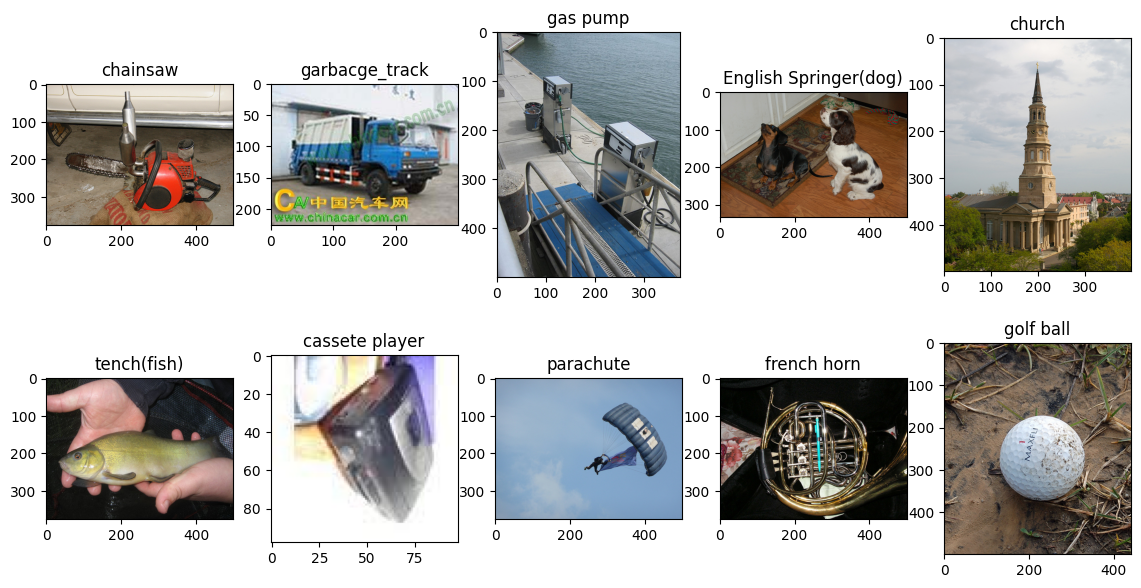

In [7]:
train_dataset.dataset.random_data_examples()

In [8]:
print(f'Train size = {len(train_dataset)}, Validation size = {len(val_dataset)}, Test size = {len(test_dataset)}')

Train size = 7575, Validation size = 1894, Test size = 3925


In [9]:
batch_size = 64
n_workers = 16
n_epochs = 100
lr= 5*1e-4

criterion = nn.CrossEntropyLoss()

In [10]:
model_eff_b0 = DataParallel(EfficientNet(net_param['efficientnet-b0']).to(device), device_ids=device_ids)
train_dataset, val_dataset = train_val_split(
    ImageNetteDataset(root_dir='data/imagenette2/train', size=net_param['efficientnet-b0'][2]), 
    val_size=0.2)
test_dataset = ImageNetteDataset(root_dir='data/imagenette2/val', size=net_param['efficientnet-b0'][2])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)

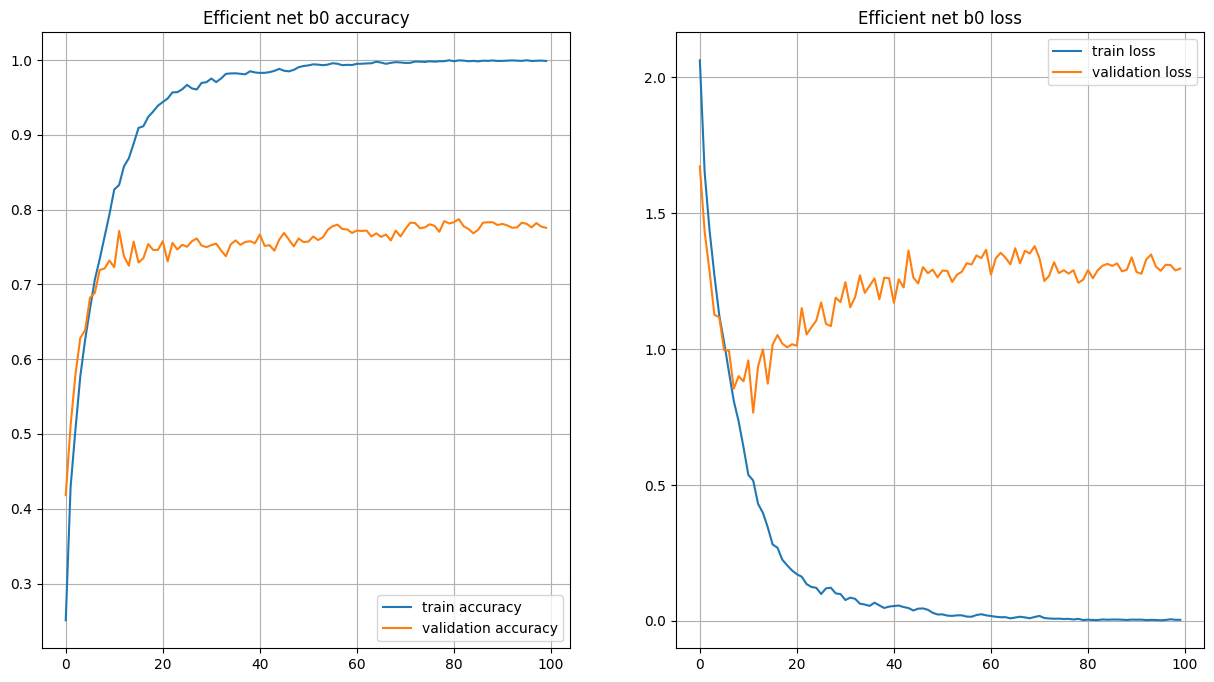

Validation accuracy: 0.776, best_val_acc: 0.787


Testing: 100%|██████████| 62/62 [00:07<00:00,  8.82it/s, accuracy=0.755]

Test accuracy of Efficient net b0 = 0.7554140127388536


In [11]:
optimizer = Adam(model_eff_b0.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
result_eff_b0 = train(
    model_eff_b0, 
    train_dataloader, 
    val_dataloader,
    test_dataloader,
    optimizer, 
    criterion, 
    device,
    scheduler, 
    n_epochs, 
    title='Efficient net b0'
)
del model_eff_b0

In [12]:
model_eff_b3 = DataParallel(EfficientNet(net_param['efficientnet-b3']).to(device), device_ids=device_ids)
train_dataset, val_dataset = train_val_split(
    ImageNetteDataset(root_dir='data/imagenette2/train', size=net_param['efficientnet-b3'][2]), 
    val_size=0.2
)
test_dataset = ImageNetteDataset(root_dir='data/imagenette2/val', size=net_param['efficientnet-b3'][2])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)

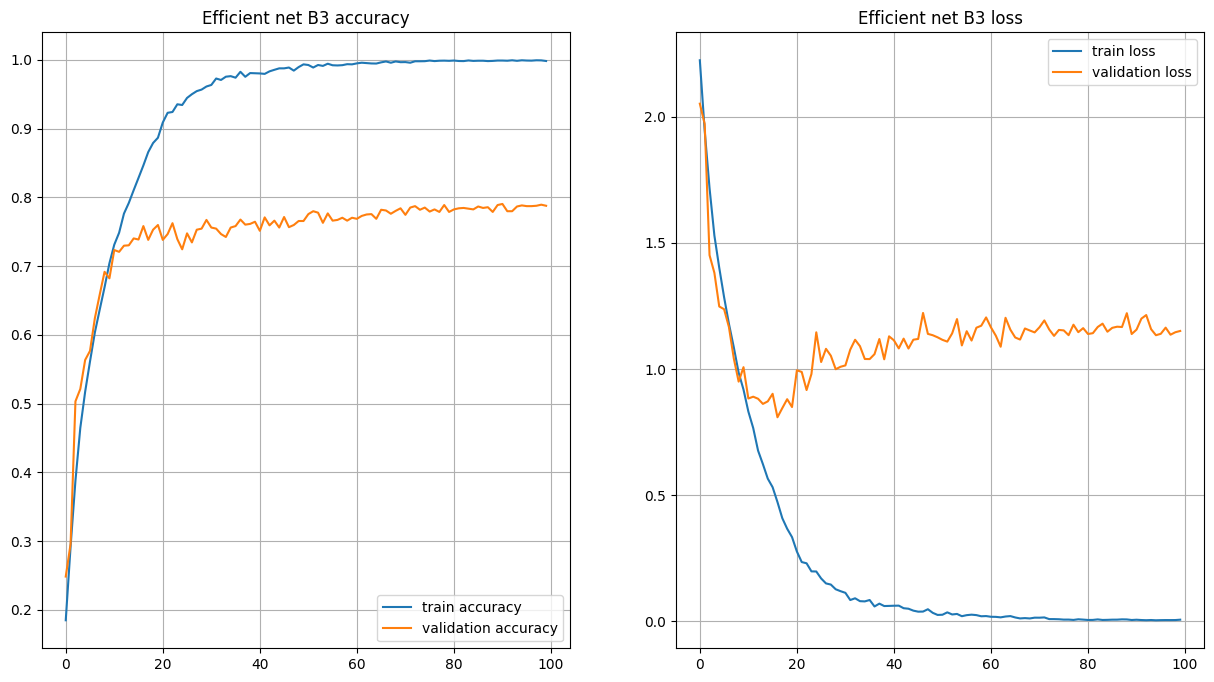

Validation accuracy: 0.788, best_val_acc: 0.790


Testing: 100%|██████████| 62/62 [00:09<00:00,  6.43it/s, accuracy=0.784]

Test accuracy of Efficient net B3 = 0.7839490445859872


In [13]:
optimizer = Adam(model_eff_b3.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
result_eff_b3 = train(
    model_eff_b3, 
    train_dataloader, 
    val_dataloader,
    test_dataloader,
    optimizer, 
    criterion, 
    device,
    scheduler, 
    n_epochs, 
    title='Efficient net B3'
)
del model_eff_b3

In [18]:
from torchvision.models import efficientnet_b0, efficientnet_b3
torchvision_eff_b0 = DataParallel(efficientnet_b0(num_classes=10).to(device), device_ids=device_ids)

train_dataset, val_dataset = train_val_split(
    ImageNetteDataset(
        root_dir='data/imagenette2/train', 
        size=net_param['efficientnet-b0'][2]), 
    val_size=0.2)
test_dataset = ImageNetteDataset(
    root_dir='data/imagenette2/val', 
    size=net_param['efficientnet-b0'][2])

batch_size = 64
num_workers = 8

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=n_workers, 
    pin_memory=True
)
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=n_workers, 
    pin_memory=True
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=n_workers,
    pin_memory=True
)

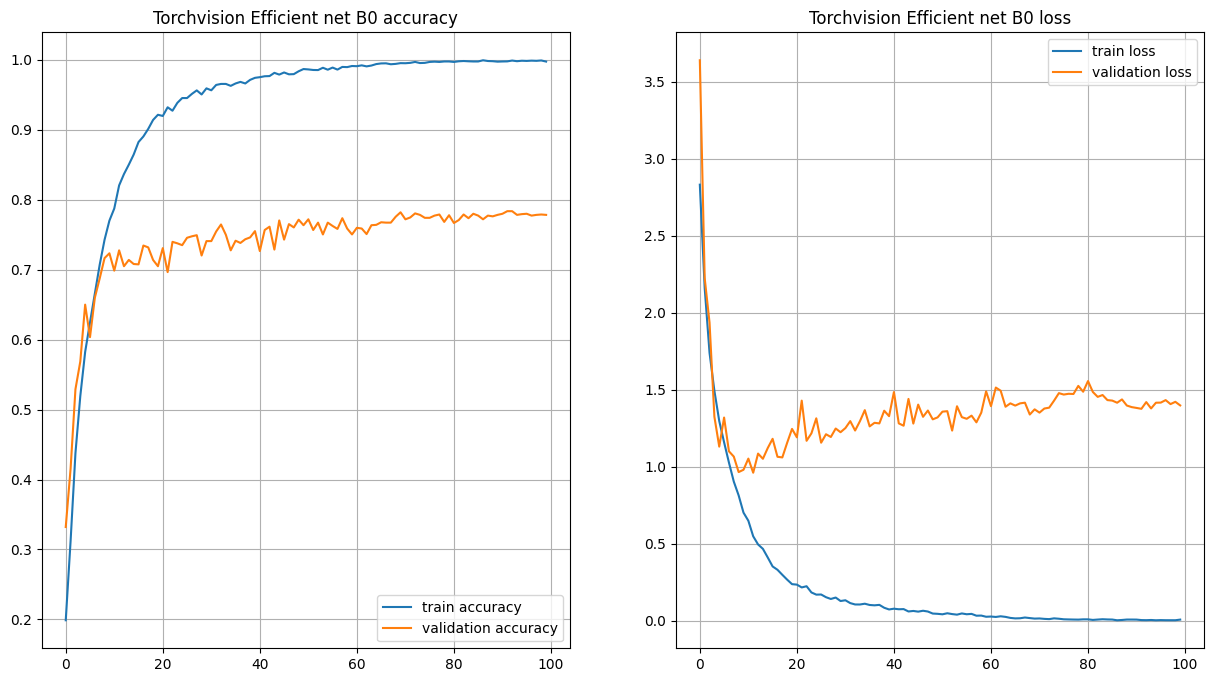

Validation accuracy: 0.778, best_val_acc: 0.784


Testing: 100%|██████████| 62/62 [00:07<00:00,  8.68it/s, accuracy=0.759]

Test accuracy of Torchvision Efficient net B0 = 0.7589808917197453


In [19]:
optimizer = Adam(torchvision_eff_b0.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
result_torchvision_b0 = train(
    torchvision_eff_b0, 
    train_dataloader, 
    val_dataloader,
    test_dataloader,
    optimizer, 
    criterion, 
    device,
    scheduler, 
    n_epochs, 
    title='Torchvision Efficient net B0'
)
del torchvision_eff_b0

In [20]:
torchvision_eff_b3 = DataParallel(efficientnet_b3(num_classes=10).to(device), device_ids=device_ids)

train_dataset, val_dataset = train_val_split(
    ImageNetteDataset(
        root_dir='data/imagenette2/train', 
        size=net_param['efficientnet-b3'][2]), 
    val_size=0.2)
test_dataset = ImageNetteDataset(
    root_dir='data/imagenette2/val', 
    size=net_param['efficientnet-b3'][2])

batch_size = 64
num_workers = 8

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=n_workers, 
    pin_memory=True
)
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=n_workers, 
    pin_memory=True
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=n_workers,
    pin_memory=True
)

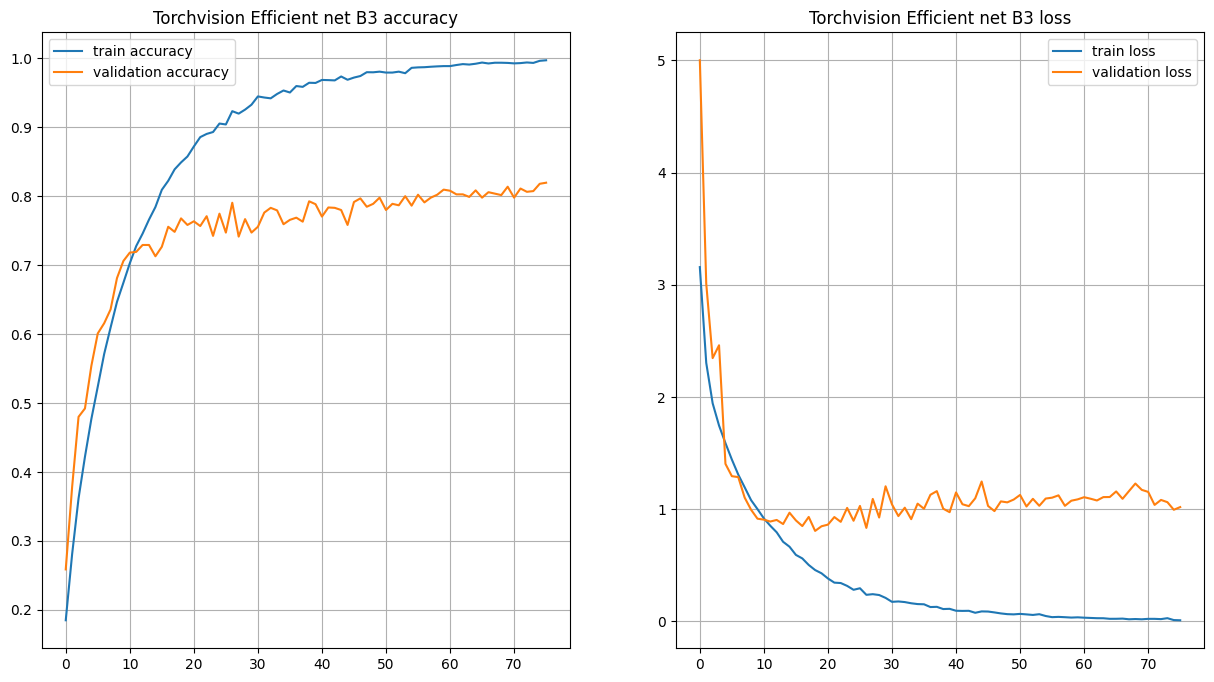

Validation accuracy: 0.819, best_val_acc: 0.819
Epoch: [77/100]


Training:  97%|█████████▋| 116/119 [00:32<00:00,  3.44it/s, loss=0.0096, train_acc=0.998] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Testing: 100%|██████████| 62/62 [00:10<00:00,  5.73it/s, accuracy=0.812]

Test accuracy of Torchvision Efficient net B3 = 0.8122292993630573


In [21]:
optimizer = Adam(torchvision_eff_b3.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
result_torchvision_b3 = train(
    torchvision_eff_b3, 
    train_dataloader, 
    val_dataloader,
    test_dataloader,
    optimizer, 
    criterion, 
    device,
    scheduler, 
    n_epochs, 
    title='Torchvision Efficient net B3'
)
del torchvision_eff_b3

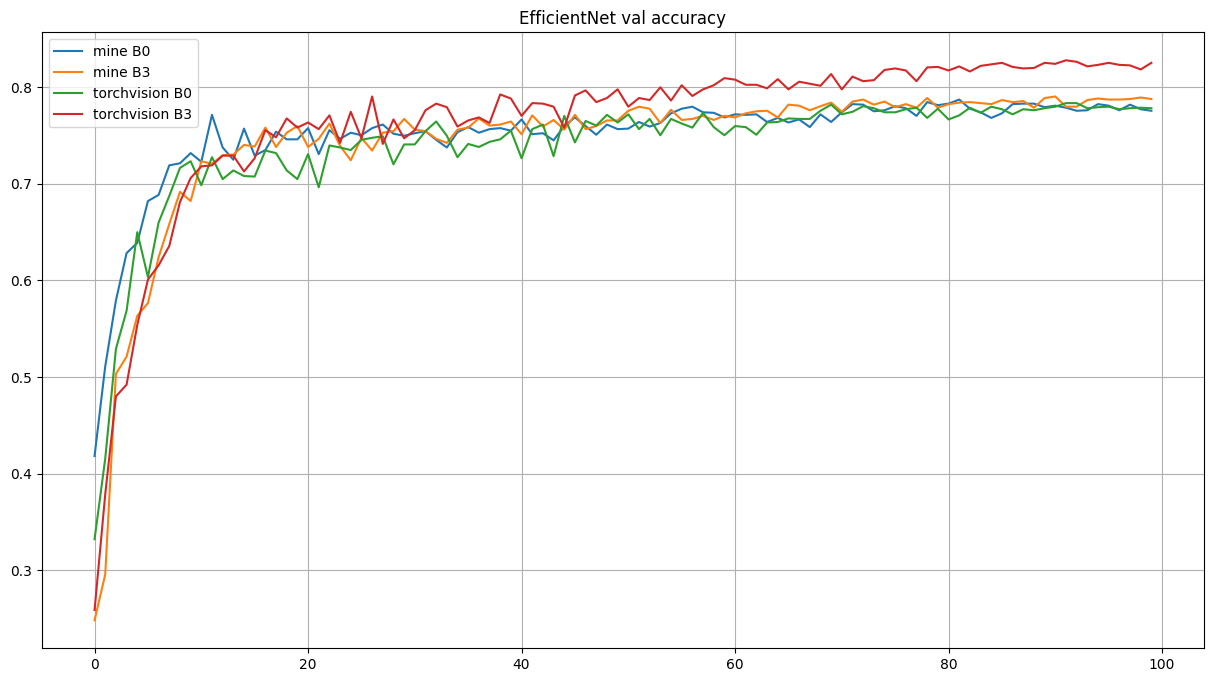

In [24]:
plt.plot(range(n_epochs), result_eff_b0['val_acc'], label='mine B0')
plt.plot(range(n_epochs), result_eff_b3['val_acc'], label='mine B3')
plt.plot(range(n_epochs), result_torchvision_b0['val_acc'], label='torchvision B0')
plt.plot(range(n_epochs), result_torchvision_b3['val_acc'], label='torchvision B3')
plt.title(label='EfficientNet val accuracy')
plt.grid()
plt.legend()
plt.show()

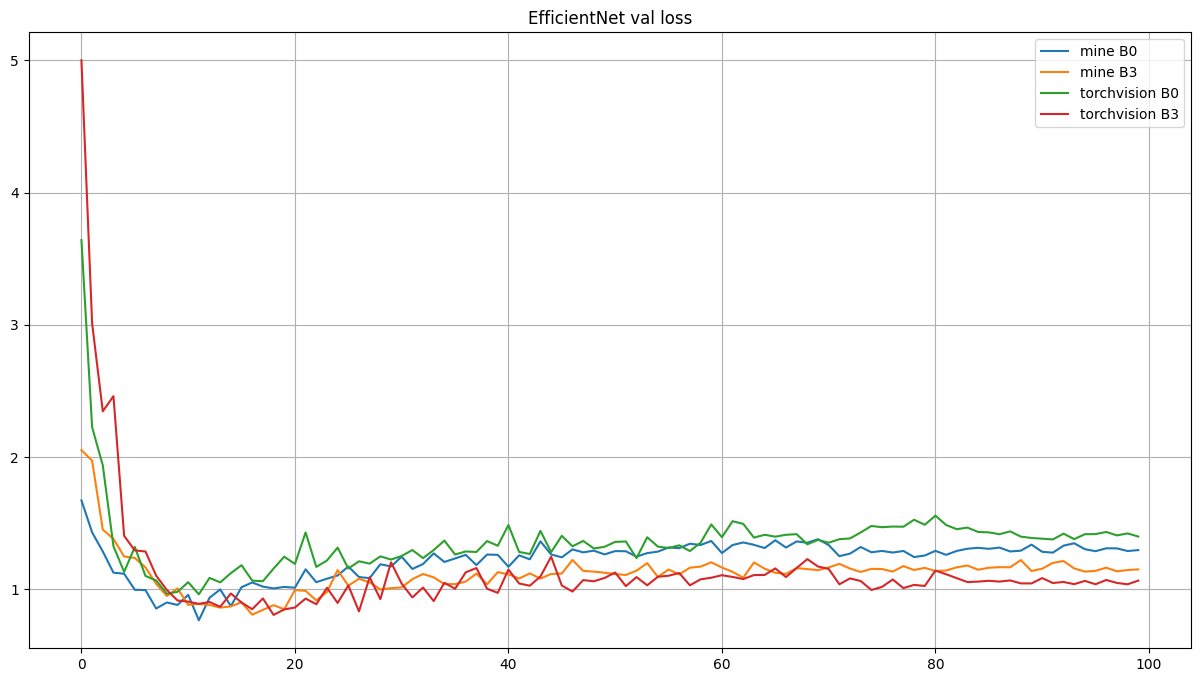

In [25]:
plt.plot(range(n_epochs), result_eff_b0['val_loss'], label='mine B0')
plt.plot(range(n_epochs), result_eff_b3['val_loss'], label='mine B3')
plt.plot(range(n_epochs), result_torchvision_b0['val_loss'], label='torchvision B0')
plt.plot(range(n_epochs), result_torchvision_b3['val_loss'], label='torchvision B3')
plt.title(label='EfficientNet val loss')
plt.grid()
plt.legend()
plt.show()

In [27]:
test_acc_b0 = result_eff_b0['test_acc']
test_acc_b3 = result_eff_b3['test_acc']
test_acc_tv_b0 = result_torchvision_b0['test_acc']
test_acc_tv_b3 = result_torchvision_b3['test_acc']

print(f'Test accuracies \nEfficientNet B0: {test_acc_b0} \
    \nEfficientNet B3: {test_acc_b3} \
    \nTorchvision EfficientNet B0: {test_acc_tv_b0} \
    \nnTorchvision EfficientNet B3: {test_acc_tv_b3}')

Test accuracies 
EfficientNet B0: 0.7554140127388536     
EfficientNet B3: 0.7839490445859872     
Torchvision EfficientNet B0: 0.7589808917197453     
nTorchvision EfficientNet B3: 0.8122292993630573
